In [1]:
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve
import json
from time import process_time
import sys


In [78]:
#Fixed parameters
sensitivity_steps = 1 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 1
annual_decisions = 2 #Number of times an agent is evaluating strategy on average
households = 10
time = 10000
mu_farm = 163.4
farm_k = 0.808 #Shape factor for farming income distribution (Weibull)
alpha = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 170

mu_migrate = 594.8
var_migrate = 998.2 ** 2
cost_migrate = 500

beta = 0.25 #Proportion of income that is shared in collective
p_drought = 0.2

discount_rate = 0.2
time_horizon = 10 #Number of cycles across which a household evaluates options

utility_function = 'Altruistic'

risk_factor = 0.5
altruism_factor = 1.0 #Degree to which individuals account for other households' utility, should range from [0,1]
max_altruism = 2.0 #Scalar by which others' utilities are multiplied, before applying altruism factor. Can take on any non-zero number. 1 = household caring about the sum of other households equally to their own for altruism factor = 1. 

k = 0.5 #Probability of an agent following another agent
sel_strength = 0.1 #Strength of selection effect
mutation_rate= 1 / households

In [3]:
#Calculate variance of truncated distributions (for drought vs. non-drought distributions)
def trunc_var(income_sample, mu):
    running_var = 0
    N = len(income_sample)
    for i in range(N):
        running_var += (income_sample[i] - mu) ** 2
    
    var = running_var / (N - 1)
    
    return var

#Define drought and non-drought portions of farming income distribution
def farm_drought(mu_farm, farm_k, p_drought):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))

    income_distribution = scale * np.random.weibull(farm_k, size=1000)
    sorted_income = list(np.sort(income_distribution))
    
    drought_threshold = int(p_drought * len(sorted_income))
    nondrought_incomes = sorted_income[drought_threshold:len(sorted_income)]
    
    if p_drought == 0:
        drought_incomes = nondrought_incomes
    else:
        drought_incomes = sorted_income[0:drought_threshold]
    
    
    mu_farm_drought = np.average(drought_incomes)
    mu_farm_nd = np.average(nondrought_incomes)
    
    var_drought = trunc_var(drought_incomes, mu_farm)
    var_nd = trunc_var(nondrought_incomes, mu_farm)
    
    return mu_farm_drought, mu_farm_nd, var_drought, var_nd
    
#Calculate variance from Weibull distribution parameters
def wei_var(mu, k):
    scale = (mu / math.gamma(1 + 1 / k))
    variance = scale ** 2 * (math.gamma(1 + 2 / k) - (math.gamma(1 + 1 / k)) ** 2)
    return variance


In [4]:
#Calculate NPV based on annual income, costs, and discount rate
def npv_calc(time_horizon, strategy, strategy_cost, farm_income, shared_income, remittances, migration_cost, discount_rate):
    income = np.zeros(time_horizon)
    costs = np.zeros(time_horizon)
    
    #Accounting for different costs/income in initial time step of migration
    if 'Migrate' in strategy:
        costs[0] = strategy_cost
        income[0] = farm_income + shared_income
        for i in range(1, time_horizon):
            income[i] = farm_income + remittances + shared_income
            costs[i] = strategy_cost - migration_cost #Becuase strategy_costs captures costs related to all strategy components
    else:
        for i in range(0, time_horizon):
            costs[i] = strategy_cost
            income[i] = farm_income + remittances + shared_income
        
    npv = 0
    for i in range(time_horizon):
        npv += (income[i] - costs[i]) / ((1 + discount_rate) ** i)
        
    return npv


# Calculate expected income from strategy options as a function of strategy distribution
def income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate):
        
    #Income generated by own household
    farm_income = {'Farm': mu_farm, 
                     'FarmMigrate': mu_farm * alpha, 
                     'Farm+Share': mu_farm, 
                     'FarmMigrate+Share': mu_farm * alpha, 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * alpha, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * alpha}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            shared_pool += beta * frequency_dist[item] * (farm_income[item] + remittances[item])
            shared_dist += frequency_dist[item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = shared_pool / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * (farm_income['Farm+Share'] + remittances['Farm+Share']), 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * (farm_income['FarmMigrate+Share'] + remittances['FarmMigrate+Share']), 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought), 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought), 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['Farm+Share+Ins'] + remittances['Farm+Share+Ins']), 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['FarmMigrate+Share+Ins'] + remittances['FarmMigrate+Share+Ins'])}
    
    expected_payoffs = {}
    for item in strategy_names:
        expected_payoffs[item] = npv_calc(time_horizon, item, costs[item], farm_income[item], shared_income_received[item], remittances[item], cost_migrate, discount_rate)
    
    return expected_payoffs
        

In [5]:
#Variance calculation

def variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_migrate, beta, frequency_dist, strategy_names, time_horizon, discount_rate):
    
    var_farm = wei_var(mu_farm, farm_k)
    
    npv_variance = {}
    
    farm_variance = {'Farm': var_farm, 
                   'FarmMigrate': (alpha ** 2) * var_farm, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': (1 - p_drought) * var_farm_nd + p_drought * var_farm_d, 
                   'FarmMigrate+Ins': (alpha ** 2) * ((1 - p_drought) * var_farm_nd + p_drought * var_farm_d), 
                   'Farm+Share+Ins': ((1 - beta) ** 2) * ((1 - p_drought) * var_farm_nd + p_drought * var_farm_d), 
                   'FarmMigrate+Share+Ins': ((1 - beta) ** 2) * ((alpha ** 2) * ((1 - p_drought) * var_farm_nd + p_drought * var_farm_d))} 
    remittance_variance = {'Farm': 0, 
                   'FarmMigrate': var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': (1 - beta) ** 2 * var_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': (1 - beta) ** 2 * var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': (1 - beta) ** 2 * var_migrate}
    
    shared_variance = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0}
    
    #Calculating variance of shared pool
    var_pool_num = 0
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            var_pool_num += (beta ** 2) * frequency_dist[item] * (farm_variance[equivalent] + remittance_variance[equivalent])
            pool_dist += frequency_dist[item]
    
    if pool_dist == 0:
        var_pool = 0
    else:
        var_pool = var_pool_num / pool_dist
    
    for item in strategy_names:
        if 'Share' in item:
            shared_variance[item] = var_pool
        
        #Calculates NPV of variance
        npv_variance[item] = npv_calc(time_horizon, item, 0, farm_variance[item], shared_variance[item], remittance_variance[item], 0, discount_rate)
    return npv_variance
            

In [6]:
# Calculation of homo economicus utility
def utility_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, var_farm_d, var_farm_nd, var_migrate, risk_factor):
    
    utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    income_matrix = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)
    variance_matrix = variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_migrate, beta, frequency_dist, strategy_names, time_horizon, discount_rate)
    
    for item in strategy_names:       
        utilities[item] = income_matrix[item] - risk_factor * math.sqrt(variance_matrix[item])
    
    return utilities

In [7]:
#Calculation of altruism utility function

#Need to do 8x8 matrix where we calculate the new distribution once for the whole timestep (rather than each time we go to a new agent)

def altruistic_util(prior_strategies, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor, max_altruism):
    
    altruistic_matrix = {'Farm': {}, 
                   'FarmMigrate': {}, 
                   'Farm+Share': {}, 
                   'FarmMigrate+Share': {}, 
                   'Farm+Ins': {}, 
                   'FarmMigrate+Ins': {}, 
                   'Farm+Share+Ins': {}, 
                   'FarmMigrate+Share+Ins': {}}
    
    strategy_names = altruistic_matrix.keys()
    

    #Updating potential frequency distributions based on household switching to another strategy
    #Here, strategy is the choice the household made in previous time step. Name represents strategy they may switch to
    for strategy in strategy_names:
        altruistic_utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
        
        for name in strategy_names:
            base_strategies = {'Farm': 0, 
                       'FarmMigrate': 0, 
                       'Farm+Share': 0, 
                       'FarmMigrate+Share': 0, 
                       'Farm+Ins': 0, 
                       'FarmMigrate+Ins': 0, 
                       'Farm+Share+Ins': 0, 
                       'FarmMigrate+Share+Ins': 0} 
            
            for item in strategy_names:
                base_strategies[item] = prior_strategies[item]
            #print('Initial distribution is:', base_strategies)   
            potential_dist = []        
            potential_dist.append(base_strategies)
            potential_dist.append(base_strategies)
           
            #Adjust strategy distributions based on one household switching to the strategy "name"
            if name != strategy and base_strategies[strategy] != 0:
                potential_dist[-1][name] = (potential_dist[-2][name] * households + 1) / households
                potential_dist[-1][strategy] = (potential_dist[-2][strategy] * households - 1) / households
                
                if potential_dist[-1][strategy] < 0:
                    raise ValueError('Distribution of:',strategy,'is negative')
                    
            #Re-calculating utility of each strategy, based on potential frequency distribution
            new_income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, potential_dist[-1], cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)
            new_variance = variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_migrate, beta, potential_dist[-1], strategy_names, time_horizon, discount_rate)      
            
            new_utility = {key : 0 for key in strategy_names}
            for i in strategy_names:
                new_utility[i] = new_income[i] - risk_factor * math.sqrt(new_variance[i])
            
        
            #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
            others_utility = 0
            
            for j in strategy_names:
                if j == name:
                    others_utility += (potential_dist[-1][j] * households - 1) * new_utility[j]
                else:
                    others_utility += potential_dist[-1][j] * households * new_utility[j]
        
            altruistic_utilities[name] = new_utility[name] + (altruism_factor / households) * max_altruism * others_utility #Normalizing altruism factor to households
        
        altruistic_matrix[strategy] = altruistic_utilities
        
        
        
    
    return altruistic_matrix
    
    
    
    

In [8]:
# Homo Moralis functions

#Function that returns probabilities of 1 --> N-1 agents adopting a strategy, given probability k
def binomial(households, k, proportion):
    current = int(proportion * households) #Existing number of households pursuing strategy
    n = households - current #Number of possible households to "convert"
    p = np.zeros(households)
    
    #If all households are already playing the strategy, assume it stays that way
    if current == households:
        p[current-1] = 1
    
    else:
        #Filling out probabilities for new converts, ranging from existing households to all households playing strategy
        for i in range(current+1, households):
            new_converts = i - current #Number of new converts needed to have i households play given strategy
            p[i] = scipy.special.comb(n, new_converts) * k ** (new_converts) * (1 - k) ** (n - new_converts)
    
        p[current] = 1 - np.sum(p) #Rest of probability remains with status quo
    
    return p

#Function that calculates probabilistic distributions for each strategy, given the prior strategy distribution
def moralis_prob(households, k, previous_dist):
    
    moralis_probabilities = {'Farm': np.zeros(households), 
                   'FarmMigrate': np.zeros(households), 
                   'Farm+Share': np.zeros(households), 
                   'FarmMigrate+Share': np.zeros(households), 
                   'Farm+Ins': np.zeros(households), 
                   'FarmMigrate+Ins': np.zeros(households), 
                   'Farm+Share+Ins': np.zeros(households), 
                   'FarmMigrate+Share+Ins': np.zeros(households)
                            }
    
    strategy_names = moralis_probabilities.keys()
    
    #Calculating probabilistic distributions for each strategy
    for strategy in strategy_names:
        moralis_probabilities[strategy] = binomial(households, k, previous_dist[strategy])
        
    return moralis_probabilities


#Function that calculates expected moralis utility, based on moralis probabilities calculated above
def moralis_utility(households, k, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor):
    strategy_names = previous_dist.keys()
    utility_matrix = {key : 0 for key in strategy_names}
    probability_matrix = moralis_prob(households, k, previous_dist)
    
    for strategy in utility_matrix.keys():
        probabilistic_income = np.zeros(households)
        probabilistic_variance = np.zeros(households)
        probabilistic_utility = np.zeros(households)
        
        for i in range(households):
            #Cutting off utility calculations for small probabilities
            if probability_matrix[strategy][i] < 0.0001:
                probabilistic_utility[i] = 0
            else:
                potential_dist = []
                moralis_dist = {key : 0 for key in strategy_names}
            
                #Calculates household strategy distribution for a given moralis probability
                moralis_dist[strategy] = (i) / households
            
                #Calculates distributions for other strategies, after accounting for same-strategy distribution
                for item in utility_matrix.keys():
                    if previous_dist[strategy] == 1:
                        moralis_dist[item] = 0
                    else:
                        moralis_dist[item] = previous_dist[item] / (1 - previous_dist[strategy]) * (1 - moralis_dist[strategy])
            
                potential_dist.append(moralis_dist)
                potential_dist.append(moralis_dist)
                probabilistic_income[i] = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, potential_dist[-1], cost_farm, cost_migrate, p_drought, time_horizon, discount_rate)[strategy]
                probabilistic_variance[i] = variance_calc(mu_farm, farm_k, p_drought, alpha, var_farm_d, var_farm_nd, var_migrate, beta, potential_dist[-1], strategy_names, time_horizon, discount_rate)[strategy]
                probabilistic_utility[i] = probabilistic_income[i] - risk_factor * math.sqrt(probabilistic_variance[i])
        

        utility_matrix[strategy] = np.dot(probability_matrix[strategy], probabilistic_utility)
    
    return utility_matrix
          

In [9]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [10]:
#Select Utility Function
def utility_select(utility_function, strategy_names, risk_factor, prior_strategies, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k):
    matrix = {key : 0 for key in strategy_names}
    if utility_function == 'Self-Interested':
        matrix = utility_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, beta, prior_strategies, cost_farm, cost_migrate, p_drought, var_farm_d, var_farm_nd, var_migrate, risk_factor)

    elif utility_function == 'Altruistic':
        matrix = altruistic_util(prior_strategies, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor, max_altruism)
    elif utility_function == 'Moralis':
        matrix = moralis_utility(households, k, prior_strategies, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor)
    else:
        raise ValueError ('Utility function improperly specified')
    
    return matrix

#Calculate probability of switching from strategy x to y

def fermi_calc(households, strategies, i, t, function, matrix, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    x_strategy = strategies[i] #Strategy of household i
    y_strategy = strategies[random_compare] #Strategy of household j
    
    #Picking utility based on type of utility function
    if utility_function == 'Altruistic':
        utility_x = matrix[x_strategy][x_strategy]
        utility_y = matrix[x_strategy][y_strategy]
    else:
        utility_x = matrix[x_strategy]
        utility_y = matrix[y_strategy]
        
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    remain_probability = (1 + math.exp(sel_strength * (utility_y - utility_x))) ** (-1)

    draw = np.random.random()
    
    if draw > remain_probability:
        new_strategy = y_strategy
    else:
        new_strategy = x_strategy

    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_names = list(matrix.keys())
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy
    
    

In [11]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




## Initialize Model

In [12]:
#Initializing Model

def _init_(households):

    frequency_matrix = {'Farm': 0, 
                  'FarmMigrate': 0, 
                  'Farm+Share': 0, 
                  'FarmMigrate+Share': 0, 
                  'Farm+Ins': 0, 
                  'FarmMigrate+Ins': 0, 
                  'Farm+Share+Ins': 0, 
                  'FarmMigrate+Share+Ins': 0}

    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)

    for i in range(households):
        draw = np.random.randint(0,options)
        initial_strategies.append(strategy_names[draw])
    
    return initial_strategies

In [64]:
#Loop through time steps
t1_start = process_time()
sens_frequency_dist = []

for step in range(sensitivity_steps):
    sim_frequency_dist = []
    
    init_sens_parameter = 0.5
    final_sens_parameter = 0.5
    
    if sensitivity_steps == 1:
        sens_parameter = init_sens_parameter
    else:
        sens_parameter = step * (final_sens_parameter - init_sens_parameter) / (sensitivity_steps-1) + init_sens_parameter
    
    altruism_factor = sens_parameter

    strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
    
    mu_farm_drought, mu_farm_nd, var_drought, var_nd = farm_drought(mu_farm, farm_k, p_drought)
    
    
    for a in range(simulations):
        print(a)
        initial_strategies = _init_(households)
        strategies = [''] * households
        strategies = initial_strategies
        frequency_dist = []
        frequency_dist.append(strategy_dist(strategies, strategy_names, households))
        
        for t in range(1, time):
            #print(t)
            matrix = utility_select(utility_function, strategy_names, risk_factor, frequency_dist[-1], households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_drought, var_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
            i = np.random.randint(0,households-1)
            updated_strategy = fermi_calc(households, strategies, i, t, utility_function, matrix, sel_strength, mutation_rate)
            strategies[i] = updated_strategy
            frequency_dist.append(strategy_dist(strategies, strategy_names,households))
        sim_frequency_dist.append(frequency_dist)
    sens_frequency_dist.append(sim_frequency_dist)

t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
prefix = 'Altruism_alpha1max2'
np.save(str(prefix) + '_frequencydist.npy', sens_frequency_dist)

0
Elapsed Time: 0.5385105499999999


# Calculating Transition Probabilities

In [59]:
#Function to calculate utilities for 2-strategy space, given distribution between the two
def edge_utility(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_Migrate, p_drought, altruism_factor, max_altruism, k):
    distribution = {key : 0 for key in strategy_names}
    utilities = {key : 0 for key in strategy_names}
    
    distribution[target_strategy] = edge_k / households
    distribution[current_strategy] = (households - edge_k) / households
    
    utilities = utility_select(utility_function, strategy_names, risk_factor, distribution, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
    
    if utility_function == 'Altruistic':
        return utilities[current_strategy][target_strategy], utilities[current_strategy][current_strategy]
    else:
        return utilities[target_strategy], utilities[current_strategy]
        

#Function to calculate probability of single step transition from current strategy to target strategy (in 2-strategy state space)
def single_step_p(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, step):
    i = str(target_strategy)
    j = str(current_strategy)
    
    edge_utilities = edge_utility(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
    
    util_i, util_j = edge_utilities
    util_gap = util_i- util_j
    
    if step == 'positive':
        #If util_gap > 709, it exceeds Python's data limit for the exp function. Probability is effectively 0 at this point
        try:
            trans_prob = (households - edge_k) / households * edge_k / (households - 1) * 1 / (1 + math.exp(-util_gap))
        except OverflowError:
            trans_prob = 0
    elif step == 'negative':
        try:
            trans_prob = (households - edge_k) / households * edge_k / (households - 1) * 1 / (1 + math.exp(util_gap))
        except OverflowError:
            trans_prob = 0
    
        
    return trans_prob

def mult_product(l, strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k):
    product = 1
    for k in range(1, l+1):
        edge_k = k
        add_p = single_step_p(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, 'positive')
        neg_p = single_step_p(strategy_names, target_strategy, current_strategy, edge_k, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, 'negative')
        try:
            ratio = neg_p/add_p
        except ZeroDivisionError:
            ratio = float('inf')
        product = product * ratio
    
    return product

def transition_probability(strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k):
    running_sum = 0
    for l in range(1, households):
        #print('Value of L is:', l)
        product = mult_product(l, strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)
        running_sum += product
    
    p = 1 / (1 + running_sum)
    
    return p


In [79]:
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

mu_farm_drought, mu_farm_nd, var_farm_d, var_farm_nd = farm_drought(mu_farm, farm_k, p_drought)

transition_matrix = {key: {} for key in strategy_names}

for name in strategy_names:
    target_strategy = name
    print('Target Strategy is:', target_strategy)
    p = {key: 0 for key in strategy_names}
    
    for item in strategy_names:
        current_strategy = item
        
        p[current_strategy] = transition_probability(strategy_names, target_strategy, current_strategy, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, alpha, mu_migrate, var_farm_d, var_farm_nd, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k)

    transition_matrix[target_strategy] = p

transition_matrix


Target Strategy is: Farm
Target Strategy is: FarmMigrate
Target Strategy is: Farm+Share
Target Strategy is: FarmMigrate+Share
Target Strategy is: Farm+Ins
Target Strategy is: FarmMigrate+Ins
Target Strategy is: Farm+Share+Ins
Target Strategy is: FarmMigrate+Share+Ins


{'Farm': {'Farm': 0.1,
  'Farm+Ins': 1.3332664154161502e-31,
  'Farm+Share': 0.0,
  'Farm+Share+Ins': 1.290211213653795e-229,
  'FarmMigrate': 0.0,
  'FarmMigrate+Ins': 0.0,
  'FarmMigrate+Share': 0.0,
  'FarmMigrate+Share+Ins': 0.0},
 'Farm+Ins': {'Farm': 0.9996289323236471,
  'Farm+Ins': 0.1,
  'Farm+Share': 0.0,
  'Farm+Share+Ins': 9.67347893161656e-199,
  'FarmMigrate': 0.0,
  'FarmMigrate+Ins': 0.0,
  'FarmMigrate+Share': 0.0,
  'FarmMigrate+Share+Ins': 0.0},
 'Farm+Share': {'Farm': 1.0,
  'Farm+Ins': 1.0,
  'Farm+Share': 0.1,
  'Farm+Share+Ins': 1.0,
  'FarmMigrate': 0.0,
  'FarmMigrate+Ins': 0.0,
  'FarmMigrate+Share': 0.0,
  'FarmMigrate+Share+Ins': 0.0},
 'Farm+Share+Ins': {'Farm': 1.0,
  'Farm+Ins': 1.0,
  'Farm+Share': 0.0,
  'Farm+Share+Ins': 0.1,
  'FarmMigrate': 0.0,
  'FarmMigrate+Ins': 0.0,
  'FarmMigrate+Share': 0.0,
  'FarmMigrate+Share+Ins': 0.0},
 'FarmMigrate': {'Farm': 1.0,
  'Farm+Ins': 1.0,
  'Farm+Share': 1.0,
  'Farm+Share+Ins': 1.0,
  'FarmMigrate': 0.1,
  'F

# Plots

## Single-Run Plot

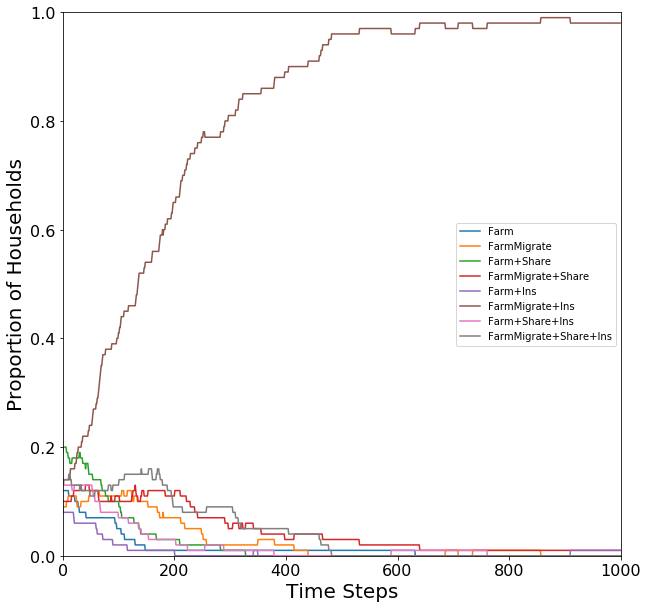

In [65]:
#Plot of strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}

for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros(time)


for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = sim_frequency_dist[0][t][item]

f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend(loc = 'center right')
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])
ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('ExampleAltruism_alpha1.eps', bbox_inches='tight')


## Average of Multiple Simulations Over Time

In [106]:
#Plot of average strategy distribution over time (averaged across simulations)

simulation_run = np.load('Self-Interested_Risk0.5_frequencydist.npy', allow_pickle = True)


local_variables = {key: [] for key in strategy_names}

avg_sim_time_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    
    local_variables[var_name] = np.zeros((simulations, time))
    for a in range(simulations):
        for t in range(time):
            local_variables[var_name][a,t] = simulation_run[-1][a][t][var_name]
    
    avg_time_distribution = np.zeros(time)
    for t in range(time):
        avg_time_distribution[t] = np.average(local_variables[var_name][:,t])
    
    avg_sim_time_distribution[var_name] = avg_time_distribution

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0, time, time)

for key in strategy_names:
    y = np.asarray(avg_sim_time_distribution[key])
    #err = np.asarray(std_final_proportion[key])
    ax.plot(x, y, label = str(key))
    #ax.fill_between(x, y - err, y + err)

    ax.set_ylim([0,1])
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Average Strategy Distribution', fontsize=20)

plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
#plt.show()

plt.savefig('Self-Interested_Risk0.5.png', bbox_inches='tight')

## Single-Parameter Sensitivity

In [32]:
#Create arrays for proportion of households in any strategy over time
parameter_array = ['0.5']

sens_frequency_dist = {}
avg_proportion = {key: [] for key in strategy_names}
std_proportion = {key: [] for key in strategy_names}

avg_final_proportion = {key: [] for key in strategy_names}
std_final_proportion = {key: [] for key in strategy_names}


for value in parameter_array:
    key = str(value)
    sens_frequency_dist[key] = np.load('Self-Interested_Risk' + str(value) + '_frequencydist.npy', allow_pickle=True)
    print(len(sens_frequency_dist[key]))
    local_variables = {}
    avg_sim_proportion = {}
    final_sim_proportion = {}
    avg_time_proportion = {}

    for item in strategy_names:
        var_name = str(item)
        local_variables[var_name] = np.zeros((simulations,time))
        avg_sim_proportion[var_name] = np.zeros(simulations)
        final_sim_proportion[var_name] = np.zeros(simulations)
        avg_time_proportion[var_name] = np.zeros(time)

    for a in range(simulations):
        for t in range(time):
            for var_name, item in zip(local_variables.keys(), strategy_names):      
                local_variables[var_name][a,t] = sens_frequency_dist[value][-1][a][t][item]

    for var_name in local_variables.keys():
        
        for sim in range(simulations):
            avg_sim_proportion[var_name][sim] = np.average(local_variables[var_name][sim,:])
            final_sim_proportion[var_name][sim] = local_variables[var_name][sim,-1]
            
        avg_proportion[var_name].append(np.average(avg_sim_proportion[var_name]))
        avg_final_proportion[var_name].append(np.average(final_sim_proportion[var_name]))
        
        std_proportion[var_name].append(np.std(avg_sim_proportion[var_name]))
        std_final_proportion[var_name].append(np.std(final_sim_proportion[var_name]))


1


IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [ ]:
#Line Plot of Avg Strategy Proportions as a function of parameter

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0.0, 1.0, 6)

for key in strategy_names:
    y = np.asarray(avg_proportion[key])
    err = np.asarray(std_proportion[key])
    ax.plot(x, y, label = str(key))
    #ax.fill_between(x, y - err, y + err)

    ax.set_ylim([0,1])
ax.set_xlabel('Moralis $k$ factor')
ax.set_ylabel('Avg Strategy Share')
plt.legend()
plt.show()

#plt.savefig('Altruistic_AltruismSens.png', bbox_inches='tight')


In [18]:
#Plot of average strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_proportion = {}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in avg_proportion.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])

ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('Altruism05.eps', bbox_inches='tight')


NameError: name 'avg_time_proportion' is not defined

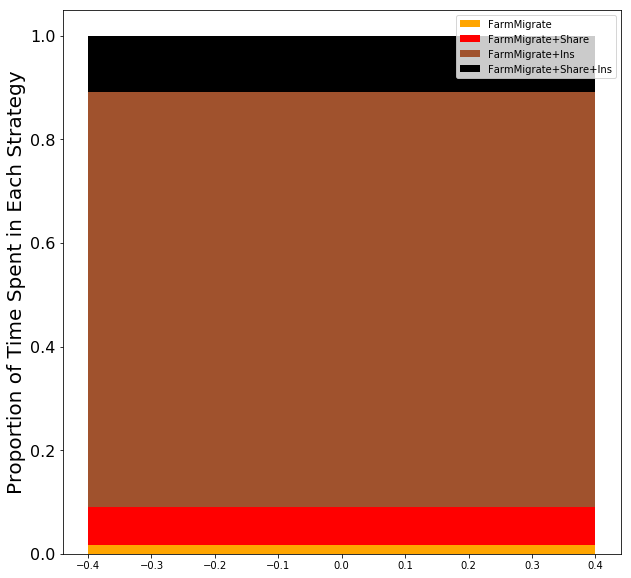

In [19]:
#Bar Graph of average strategy distributions over simulations

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_time_proportion = {}
avg_proportion={}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])



f, ax = plt.subplots(figsize=[10,10])
x = np.arange(time)

categories = np.arange(1)
ax.bar(categories, avg_proportion['FarmMigrate'], label='FarmMigrate', color='orange')
ax.bar(categories, avg_proportion['FarmMigrate+Share'], bottom=avg_proportion['FarmMigrate'], label='FarmMigrate+Share', color='red')
ax.bar(categories, avg_proportion['FarmMigrate+Ins'], bottom=(avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Ins', color='sienna')
ax.bar(categories, avg_proportion['FarmMigrate+Share+Ins'], bottom=(avg_proportion['FarmMigrate+Ins'] + avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Share+Ins', color='black')

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()

#ax1.set_xlabel('Time Steps', size=20)
ax.set_ylabel('Proportion of Time Spent in Each Strategy', size=20)

plt.yticks(fontsize=16)
plt.show()

#np.save(avg_proportion, 'P0.3_proportion_10sim.npy')

#print(type(avg_proportion))
#data = json.dumps(avg_proportion)
#f = open("P0.01_proportion.json","w")
#f.write(data)
#f.close()

#plt.savefig('Altruism05_10sim.eps', bbox_inches='tight')

In [11]:
# Create Bar plot with separate bars for each drought probability tested

probabilities = [0.01, 0.05, 0.1, 0.3]
local_variables = {}
means = {'FarmMigrate':[], 'FarmMigrate+Share':[], 'FarmMigrate+Ins':[], 'FarmMigrate+Share+Ins':[]}



for item in probabilities:
    
    f = open('P' + str(item) + '_proportion.json',)
    var_name = ('p_' + str(item))
    local_variables[var_name] = json.load(f)
    f.close()


categories = means.keys()

for strategy in categories:
    for key,value in local_variables.items():
        means[strategy].append(local_variables[key][strategy])

probability_order = list(local_variables.keys())

f, ax = plt.subplots(figsize=[10,10])

bottom_1 = means['FarmMigrate']
bottom_2 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] for i in range(len(means['FarmMigrate']))]
bottom_3 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] + means['FarmMigrate+Ins'][i] for i in range(len(means['FarmMigrate']))]

#[test_list1[i] + test_list2[i] for i in range(len(test_list1))]
ax.bar(probability_order, means['FarmMigrate'], label = 'FarmMigrate', color='dodgerblue')
ax.bar(probability_order, means['FarmMigrate+Share'], bottom = bottom_1, label = 'FarmMigrate+Share', color='green')
ax.bar(probability_order, means['FarmMigrate+Ins'], bottom = bottom_2, label = 'FarmMigrate+Ins', color='salmon')
ax.bar(probability_order, means['FarmMigrate+Share+Ins'], bottom = bottom_3, label = 'FarmMigrate+Share+Ins', color='darkorchid')

ax.set_xlabel('Drought Probability', size=18)
ax.set_ylabel('Proportion of Time', size=18)


plt.legend(fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.show()

plt.savefig('DroughtSensitivity.eps', bbox_inches='tight')